### Training Logistic Regression via Stochastic Gradient Ascent

The goal of this assignment is to implement a logistic regression classifier using stochastic gradient ascent. You will:

Extract features from Amazon product reviews.

Convert an SFrame into a NumPy array.

Write a function to compute the derivative of log likelihood function (with L2 penalty) with respect to a single coefficient.

Implement stochastic gradient ascent with L2 penalty

Compare convergence of stochastic gradient ascent with that of batch gradient ascent

https://github.com/yiliang-Liu/Online-Courses/blob/master/Machine%20Learning-Classification/Week2_Assignment2.ipynb 

https://github.com/hoang6/UW-MachineLearning/blob/master/Course3-Classification/module-10-online-learning-assignment-blank.ipynb

In [1]:
import numpy as np
import pandas as pd
import string
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()

In [2]:
def remove_punctuation(text):
    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table)

#### For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews. Load the data file into a data frame products.

In [3]:
products = pd.read_csv('amazon_baby_subset.csv')
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [7]:
# fill in N/A's in the review column
products = products.fillna({'review':''})

### Apply text cleaning on the review data

In this section, we will perform some simple feature cleaning using data frames. The last assignment used all words in building bag-of-words features, but here we limit ourselves to 193 words (for simplicity). We compiled a list of 193 most frequent words into the JSON file named important_words.json. Load the words into a list important_words.

Let us perform 2 simple data transformations:

1. Remove punctuation

2. Compute word counts (only for important_words)

In [8]:
important_words = pd.read_json('important_words.json')[0].tolist()

In [9]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [10]:
products.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


#### Now we proceed with the second item. For each word in important_words, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in important_words which keeps a count of the number of times the respective word occurs in the review text.

Note: There are several ways of doing this. One way is to create an anonymous function that counts the occurrence of a particular word and apply it to every element in the review_clean column. Repeat this step for every word in important_words. Your code should be analogous to the following:

In [11]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [13]:
train_idx = pd.read_json('module-10-assignment-train-idx.json')
validation_idx = pd.read_json('module-10-assignment-validation-idx.json')

In [15]:
train_data = products.iloc[train_idx[0]]
validation_data = products.iloc[validation_idx[0]]

### Convert train_data and validation_data into multi-dimensional arrays.

Using the function given in #8 of Module 3 assignment, extract two arrays feature_matrix_train and sentiment_train from train_data. The 2D array feature_matrix_train would contain the content of the columns given by the list important_words. The 1D array sentiment_train would contain the content of the column sentiment. Do the same for validation_data, producing the arrays feature_matrix_valid and sentiment_valid. The code should be analogous to this cell:

In [59]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    """
        products.head()[['name', 'rating']].values == products.head().as_matrix(columns=['name', 'rating'])
        use as_matrix() function 
        can also use df.values function 
        https://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array-preserving-index
        https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.as_matrix.html
    
    """
    feature_matrix = dataframe.as_matrix(columns=features)
    label_array = dataframe[label].as_matrix()
    
    return feature_matrix, label_array

In [60]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

f:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
f:\anaconda\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
f:\anaconda\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


(47780,)

In [26]:
sentiment_train.shape

(47780, 1)

In [27]:
feature_matrix_train.shape

(47780, 194)

#### Quiz question: In Module 3 assignment, there were 194 features (an intercept + one feature for each of the 193 important words). In this assignment, we will use stochastic gradient ascent to train the classifier using logistic regression. How does the changing the solver to stochastic gradient ascent affect the number of features? -----> I think there is no affect. 

### Building on logistic regression
Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of important_words in the review $\mathbf{x}_i$.

We will use the same code as in Module 3 assignment to make probability predictions, since this part is not affected by using stochastic gradient ascent as a solver. Only the way in which the coefficients are learned is affected by using stochastic gradient ascent as a solver.

In [28]:
def predict_probability(feature_matrix, coefficients):
    '''
        produces probablistic estimate for P(y_i = +1 | x_i, w).
        estimate ranges between 0 and 1.
    '''
    # Take dot product of feature_matrix and coefficients  
    # score is len(feature_matrix) * 1  vector
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # predictions is len(feature_matrix) * 1  vector
    predictions = 1 / (1 + np.exp(-score))
    
    # return predictions
    return predictions

### Derivative of log likelihood with respect to a single coefficient
Let us now work on making minor changes to how the derivative computation is performed for logistic regression.
Recall from the lectures and Module 3 assignment that for logistic regression, the derivative of log likelihood with respect to a single coefficient is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$
In Module 3 assignment, we wrote a function feature_derivative to compute the derivative of log likelihood with respect to a single coefficient $w_j$. 

The function accepts the following two parameters:
errors vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
feature vector containing $h_j(\mathbf{x}_i)$ for all $i$

Complete the following code block:

Note. We are not using regularization in this assignment, but, as discussed in the optional video, stochastic gradient can also be used for regularized logistic regression.

In [32]:
def feature_derivative(errors, feature): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE small confusion, why this order? 
    derivative = np.dot(errors, feature)
    """
    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative -= 2 * l2_penalty * coefficient
    """ 
    return derivative

#### Note. 
We are not using regularization in this assignment, but, as discussed in the optional video, stochastic gradient can also be used for regularized logistic regression.

To verify the correctness of the gradient computation, we provide a function for computing average log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

To track the performance of stochastic gradient ascent, we provide a function for computing average log likelihood.
$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$
Note that we made one tiny modification to the log likelihood function (called compute_log_likelihood) in our earlier assignments. We added a $\color{red}{1/N}$ term which averages the log likelihood accross all data points. The $\color{red}{1/N}$ term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. We will use this function to generate plots that are similar to those you saw in the lecture.

In [34]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

Quiz Question: Recall from the lecture and the earlier assignment, the log likelihood (without the averaging term) is given by
$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$
How are the functions $\ell\ell(\mathbf{w})$ and $\ell\ell_A(\mathbf{w})$ related?

### Modifying the derivative for stochastic gradient ascent
Recall from the lecture that the gradient for a single data point $\color{red}{\mathbf{x}_i}$ can be computed using the following formula:
$$
\frac{\partial\ell_{\color{red}{i}}(\mathbf{w})}{\partial w_j} = h_j(\color{red}{\mathbf{x}_i})\left(\mathbf{1}[y_\color{red}{i} = +1] - P(y_\color{red}{i} = +1 | \color{red}{\mathbf{x}_i}, \mathbf{w})\right)
$$

Computing the gradient for a single data point

Do we really need to re-write all our code to modify $\partial\ell(\mathbf{w})/\partial w_j$ to $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$?

Thankfully No!. Using NumPy, we access $\mathbf{x}_i$ in the training data using feature_matrix_train[i:i+1,:] and $y_i$ in the training data using sentiment_train[i:i+1]. We can compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ by re-using all the code written in feature_derivative and predict_probability.

Carry out the following steps:
1. First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the predict_probability function with feature_matrix_train[i:i+1,:] as the first parameter.
2. Next, compute $\mathbf{1}[y_i = +1]$ using sentiment_train[i:i+1].
3. Finally, call the feature_derivative function with feature_matrix_train[i:i+1, j] as one of the parameters.

Let us follow these steps for j = 1 and i = 10:

In [61]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print( "Gradient single data point: %s" % gradient_single_data_point)
print( "           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


#### Quiz Question: The code block above computed $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$ for j = 1 and i = 10. 

Is $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$ a scalar or a 194-dimensional vector? --> Scalar

The derivative is always scalar in both gradient methods.

### Modifying the derivative for using a batch of data points

Stochastic gradient estimates the ascent direction using 1 data point, while gradient uses $N$ data points to decide how to update the the parameters. 

In an optional video, we discussed the details of a simple change that allows us to use a mini-batch of $B \leq N$ data points to estimate the ascent direction. This simple approach is faster than regular gradient but less noisy than stochastic gradient that uses only 1 data point. Although we encorage you to watch the optional video on the topic to better understand why mini-batches help stochastic gradient, in this assignment, we will simply use this technique, since the approach is very simple and will improve your results.
Given a mini-batch (or a set of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by: $$
\color{red}{\sum_{s = i}^{i+B}} \frac{\partial\ell_{s}}{\partial w_j} = \color{red}{\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
Computing the gradient for a "mini-batch" of data points
Using NumPy, we access the points $\mathbf{x}_i, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$ in the training data using feature_matrix_train[i:i+B,:] and $y_i$ in the training data using sentiment_train[i:i+B].
We can compute $\color{red}{\sum_{s = i}^{i+B}} \partial\ell_{s}/\partial w_j$ easily as follows:

In [63]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print( "Gradient mini-batch data points: %s" % gradient_mini_batch)
print( "                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


In [84]:
feature_matrix_train[i:i+B,j].shape

(10,)

In [73]:
feature_matrix_train.shape

(47780, 194)

In [77]:
train_data.as_matrix(columns=['sentiment']).shape

f:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(47780, 1)

In [82]:
train_data['sentiment'].as_matrix().shape

f:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(47780,)

Quiz Question: The code block above computed  $\color{red}{\sum_{s = i}^{i+B}}\partial\ell_{s}(\mathbf{w})/{\partial w_j}$ for j = 10, i = 10, and B = 10. Is this a scalar or a 194-dimensional vector? ---> Scalar

Quiz Question: For what value of B is the term $\color{red}{\sum_{s = 1}^{B}}\partial\ell_{s}(\mathbf{w})/\partial w_j$ the same as the full gradient $\partial\ell(\mathbf{w})/{\partial w_j}$?  ---> B = N

In [124]:
len(train_data)

47780

### Averaging the gradient across a batch
It is a common practice to normalize the gradient update rule by the batch size B:
$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the average gradient over data points (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of all the data points), and study the effect of batch size on the algorithm as well as the choice of step size.

Now we are ready to implement our own logistic regression with stochastic gradient ascent. 

The function logistic_regression_SG should accept the following parameters:

1. feature_matrix: 2D array of features
2. sentiment: 1D array of class labels
3. initial_coefficients: 1D array containing initial values of coefficients
4. step_size: a parameter controlling the size of the gradient steps
5. batch_size: size of mini-batch
6. max_iter: number of iterations to run stochastic gradient ascent

The function should return the final set of coefficients, along with the list of log likelihood values over time. (In practice, the final set of coefficients is rarely used; it is better to use the average of the last K sets of coefficients instead, where K should be adjusted depending on how fast the log likelihood oscillates around the optimum.)

The function logistic_regression_SG carries out the steps shown in the following pseudocode:

* Create an empty list called log_likelihood_all
* Initialize coefficients to initial_coefficients
* Set random seed = 1
* Shuffle the data before starting the loop below
* Set i = 0, the index of current batch

* Run the following steps max_iter times, performing linear scans over the data:
  * Predict P(y_i = +1|x_i,w) using your predict_probability() function
    Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
  * Compute indicator value for (y_i = +1)
    Make sure to slice the i-th entry with [i:i+batch_size]
  * Compute the errors as (indicator - predictions)
  * For each coefficients[j]:
    - Compute the derivative for coefficients[j] and save it to derivative.
      Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
    - Compute the product of the step size, the derivative, and (1./batch_size).
    - Increment coefficients[j] by the product just computed.
  * Compute the average log likelihood over the current batch.
    Add this value to the list log_likelihood_all.
  * Increment i by batch_size, indicating the progress made so far on the data.
  * Check whether we made a complete pass over data by checking
    whether (i+batch_size) exceeds the data size. If so, shuffle the data. If not, do nothing.

* Return the final set of coefficients, along with the list log_likelihood_all.

In [86]:
feature_matrix_train.shape

(47780, 194)

In [88]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        predictions = predict_probability(feature_matrix[i:i+batch_size, :], coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        indicator = (sentiment[i:i+batch_size] == +1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size, j])
                  # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            coefficients[j] += 1./batch_size * step_size * derivative

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print( 'Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))  

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [89]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print( '-------------------------------------------------------------------------------------')
print( 'Coefficients learned                 :', coefficients)
print( 'Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print( '-------------------------------------------------------------------------------------')
    print( 'Test passed!')
else:
    print( '-------------------------------------------------------------------------------------')
    print( 'Test failed')

Iteration 0: Average log likelihood (of data points  [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points  [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


#### Compare convergence behavior of stochastic gradient ascent

For the remainder of the assignment, we will compare stochastic gradient ascent against batch gradient ascent. For this, we need a reference implementation of batch gradient ascent. But do we need to implement this from scratch?

Quiz Question: For what value of batch size B above is the stochastic gradient ascent function logistic_regression_SG act as a standard gradient ascent algorithm? ---> N

### Running gradient ascent using the stochastic gradient ascent implementation

Instead of implementing batch gradient ascent separately, we save time by re-using the stochastic gradient ascent function we just wrote — to perform gradient ascent, it suffices to set batch_size to the number of data points in the training data. Yes, we did answer above the quiz question for you, but that is an important point to remember in the future :)

Small Caveat. The batch gradient ascent implementation here is slightly different than the one in the earlier assignments, as we now normalize the gradient update rule.

We now run stochastic gradient ascent over the feature_matrix_train for 10 iterations using:

1. initial_coefficients = np.zeros(194)
2. step_size = 5e-1
3. batch_size = 1
4. max_iter = 10

Quiz Question. When you set batch_size = 1, as each iteration passes, how does the average log likelihood in the batch change? 

In [91]:
coefficients_1, log_likelihood_1 = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


#### Now run batch gradient ascent over the feature_matrix_train for 200 iterations using:

1. initial_coefficients = np.zeros(194)
2. step_size = 5e-1
3. batch_size = number of rows in feature_matrix_train
4. max_iter = 200

Quiz Question. When you set batch_size = len(train_data), as each iteration passes, how does the average log likelihood in the batch change?

In [108]:
coefficients_N, log_likelihood_N = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=len(train_data), max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

### Make "passes" over the dataset
To make a fair comparison betweeen stochastic gradient ascent and batch gradient ascent, we measure the average log likelihood as a function of the number of passes (defined as follows): $$
[\text{# of passes}] = \frac{[\text{# of data points touched so far}]}{[\text{size of dataset}]}
$$

Quiz Question Suppose that we run stochastic gradient ascent with a batch size of 100. How many gradient updates are performed at the end of two passes over a dataset consisting of 50000 data points? 

---->1000

### Log likelihood plots for stochastic gradient ascent

With the terminology in mind, let us run stochastic gradient ascent for 10 passes. We will use

1. step_size=1e-1
2. batch_size=100
3. initial_coefficients set to all zeros.

The function should first compute moving averages of log_likelihood_all. To do this efficiently, convolve log_likelihood_all with the vector of length smoothing_window that is filled with the value 1/smoothing_window.

The function then plot the moving averages over the number of passes over the data. Use len_data and batch_size to convert iteration number of (fractional) number of passes.

In [137]:
def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    # it is moving average here
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})
#     plt.show()

In [94]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

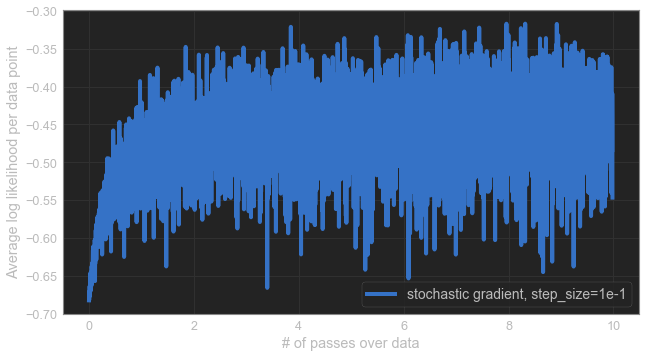

In [95]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

In [102]:
np.convolve(np.array([1,2,3,4, 5, 6]), np.ones((2,))/2, mode='valid')

array([1.5, 2.5, 3.5, 4.5, 5.5])

In [104]:
pd.Series([1,2,3,4, 5, 6]).rolling(2).mean()

0    NaN
1    1.5
2    2.5
3    3.5
4    4.5
5    5.5
dtype: float64

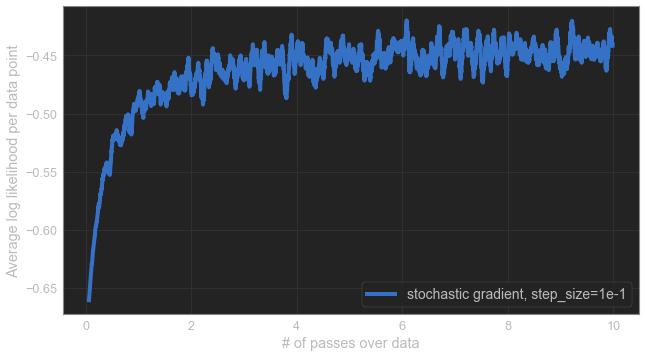

In [105]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

### Stochastic gradient ascent vs batch gradient ascent
To compare convergence rates for stochastic gradient ascent with batch gradient ascent, we call make_plot() multiple times in the same cell.

We are comparing:
stochastic gradient ascent: step_size = 0.1, batch_size=100

batch gradient ascent: step_size = 0.5, batch_size=len(feature_matrix_train)

Write code to run stochastic gradient ascent for 200 passes using:
1. step_size=1e-1
2. batch_size=100
3. initial_coefficients to all zeros.

In [107]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

## YOUR CODE HERE
coefficients_sgd_200, log_likelihood_sgd_200 = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

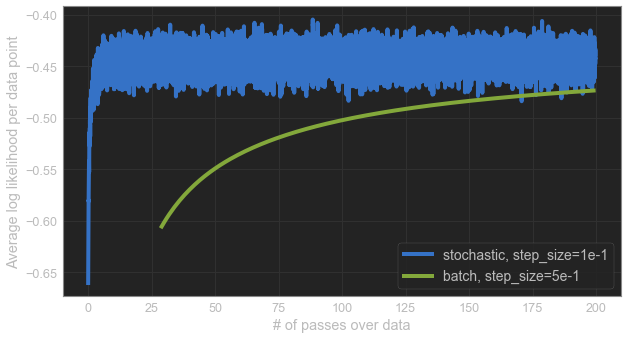

In [128]:
# make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
#           smoothing_window=30, label='stochastic, step_size=1e-1')
# make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
#           smoothing_window=1, label='batch, step_size=5e-1')
make_plot(log_likelihood_sgd_200, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_N, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=30, label='batch, step_size=5e-1')

#### Quiz Question: In the figure above, how many passes does batch gradient ascent need to achieve a similar log likelihood as stochastic gradient ascent?  ---> 200

### Explore the effects of step sizes on stochastic gradient ascent

In previous sections, we chose step sizes for you. In practice, it helps to know how to choose good step sizes yourself.

To start, we explore a wide range of step sizes that are equally spaced in the log space. Run stochastic gradient ascent with step_size set to 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, and 1e2. Use

1. initial_coefficients=np.zeros(194)
2. batch_size=100
3. max_iter initialized so as to run 10 passes over the data.

Plotting the log likelihood as a function of passes for each step size

Now, we will plot the change in log likelihood using the make_plot for each of the following values of step_size:

1. step_size = 1e-4
2. step_size = 1e-3
3. step_size = 1e-2
4. step_size = 1e-1
5. step_size = 1e0
6. step_size = 1e1
7. step_size = 1e2

For consistency, use smoothing_window=30.

Quiz Question: Which of the following is the worst step size? Pick the step size that results in the lowest log likelihood in the end.

Quiz Question: Which of the following is the best step size? Pick the step size that results in the highest log likelihood in the end.

In [135]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd_para = {}
log_likelihood_sgd_para = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd_para[step_size], log_likelihood_sgd_para[step_size] = logistic_regression_SG(feature_matrix_train,sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

Iteration  200: Average log likelihood (of data points  [20000:20100]) = -0.54566060
Iteration  300: Average log likelihood (of data points  [30000:30100]) = -0.48245740
Iteration  400: Average log likelihood (of data points  [40000:40100]) = -0.46629313
Iteration  500: Average log likelihood (of data points  [02300:02400]) = -0.47223389
Iteration  600: Average log likelihood (of data points  [12300:12400]) = -0.52216798
Iteration  700: Average log likelihood (of data points  [22300:22400]) = -0.52336683
Iteration  800: Average log likelihood (of data points  [32300:32400]) = -0.46963453
Iteration  900: Average log likelihood (of data points  [42300:42400]) = -0.47883783
Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -0.46988191
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -0.46365531
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -0.36466901
Iteration 4000: Average log likelihood (of data points  [18400:18

Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -3.85009220
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -10.04749756
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -1.77794016
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -32.33144748
Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -7.17985663


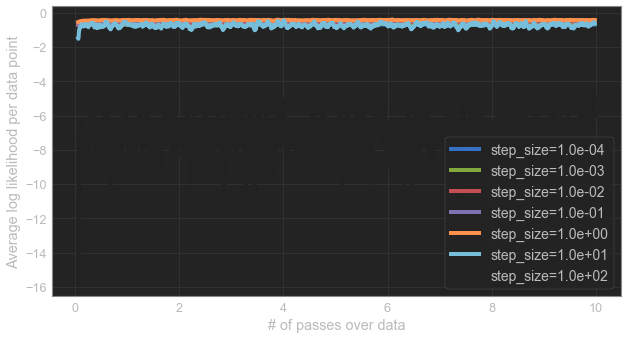

In [138]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd_para[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)


In [140]:
for step_size in np.logspace(-4, 2, num=7):
    print(step_size, np.mean(log_likelihood_sgd_para[step_size]))

0.0001 -0.6883656809634472
0.001 -0.6547494785195667
0.01 -0.5484200314929581
0.1 -0.464138782231857
1.0 -0.4245318894527169
10.0 -0.7237105039821737
100.0 -7.344562350489837
